In [2]:
# Import necessary libraries
def install(package):
    subprocess.check_call(["uv", "pip", "install", "--upgrade", package])
try:
    import sys
    import subprocess
    import nltk
    import re
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    # import hdbscan
    import umap
    import optuna
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
    from sklearn.decomposition import PCA, IncrementalPCA
    from sklearn.metrics import silhouette_score, davies_bouldin_score
    #from sklearn.model_selection import train_test_split
    from nltk.corpus import stopwords
    #from sklearn.decomposition import TruncatedSVD
    import warnings
    warnings.filterwarnings('ignore')
except ImportError:
    print("Some packages are required to be installed")
    print("Installing expected packages")
    install('pip')
    install('nltk')
    # install('matplotlib')
    # install('hdbscan')
    install('umap-learn')
    install('optuna')
    install('scikit-learn')
    install('plotly')

In [3]:
# Load the dataset
df = pd.read_csv('twitter_user_data.csv', encoding='ISO-8859-1')

# Quick view of the dataset
print('The information of the dataset')
print(df.info())
print('The first few rows of the dataset')
print(df.head())

The information of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   

the _unit_id has 0 data missing
the proportion of missing data to the total is 0.0
the _golden has 0 data missing
the proportion of missing data to the total is 0.0
the _unit_state has 0 data missing
the proportion of missing data to the total is 0.0
the _trusted_judgments has 0 data missing
the proportion of missing data to the total is 0.0
the _last_judgment_at has 50 data missing
the proportion of missing data to the total is 0.0024937655860349127
the gender has 97 data missing
the proportion of missing data to the total is 0.00483790523690773
the gender:confidence has 26 data missing
the proportion of missing data to the total is 0.0012967581047381546
the profile_yn has 0 data missing
the proportion of missing data to the total is 0.0
the profile_yn:confidence has 0 data missing
the proportion of missing data to the total is 0.0
the created has 0 data missing
the proportion of missing data to the total is 0.0
the description has 3744 data missing
the proportion of missing data to t

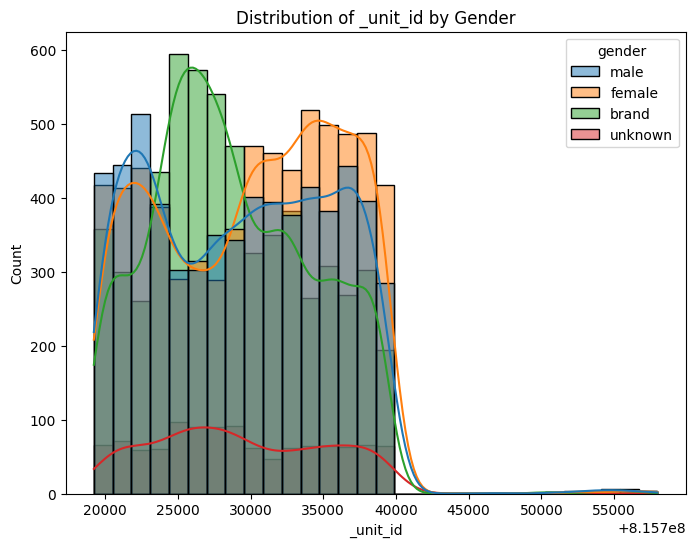

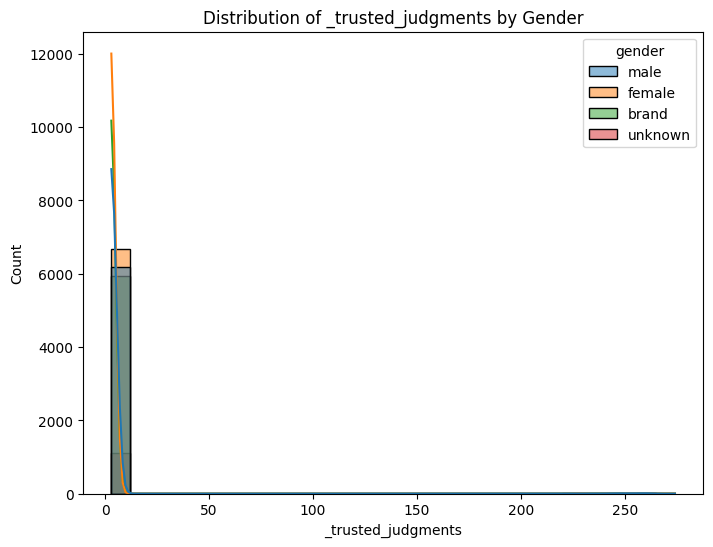

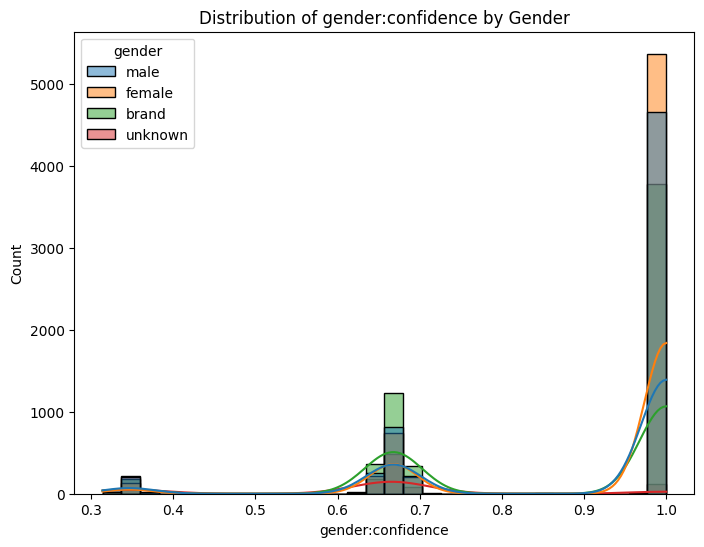

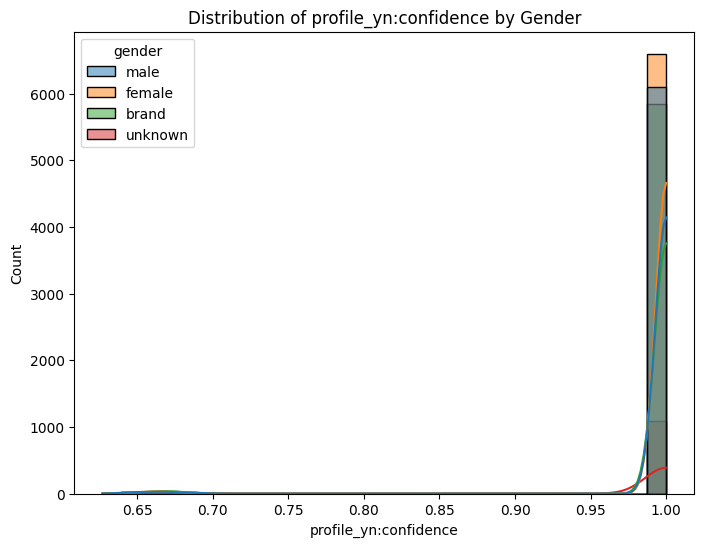

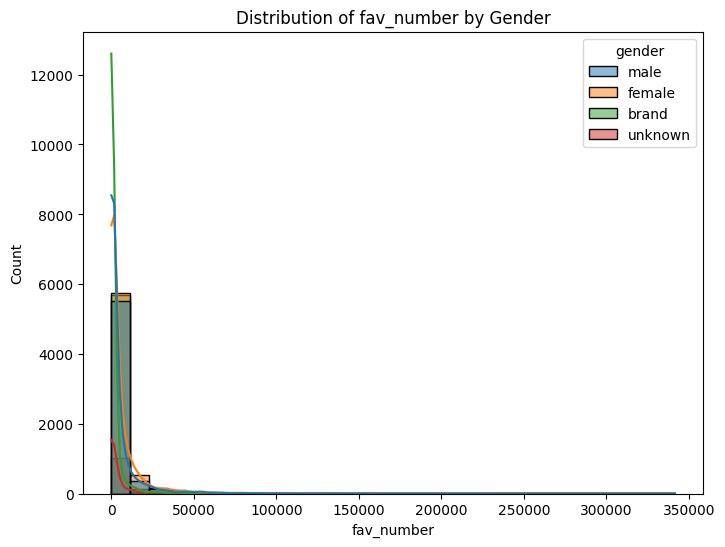

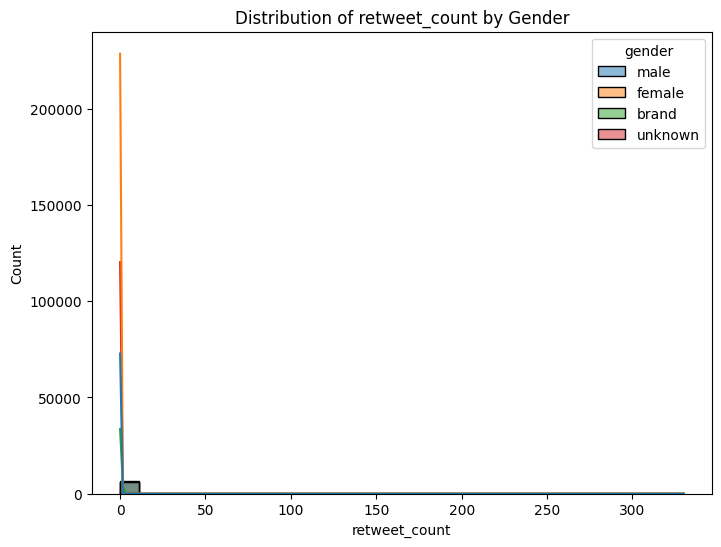

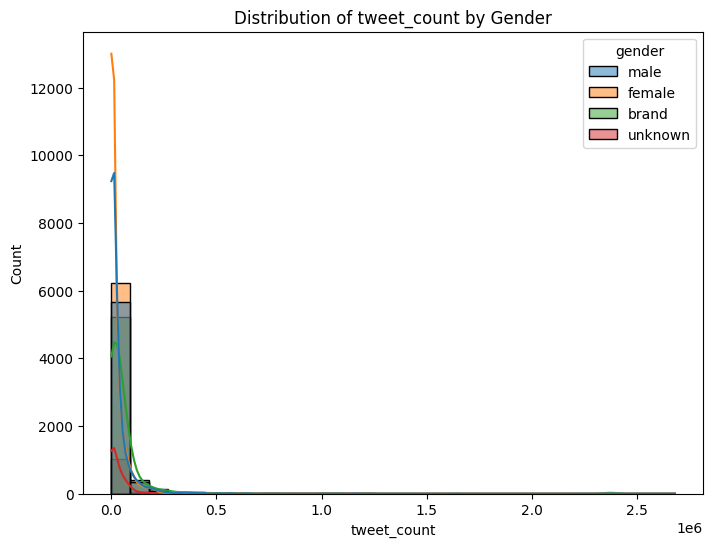

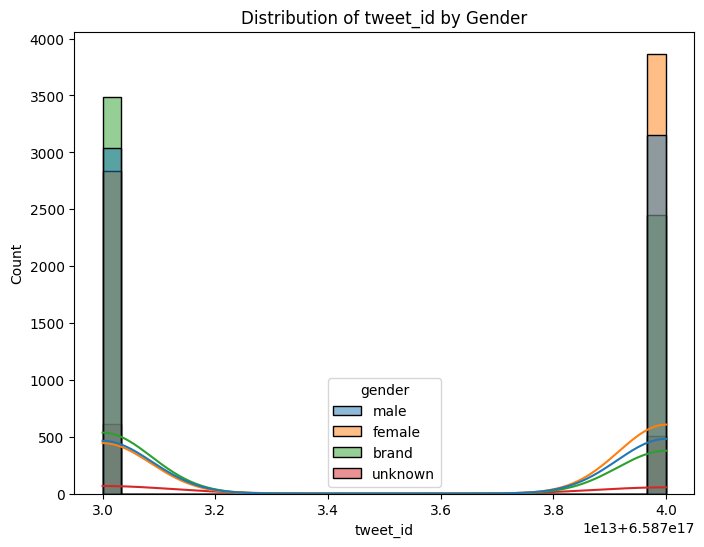

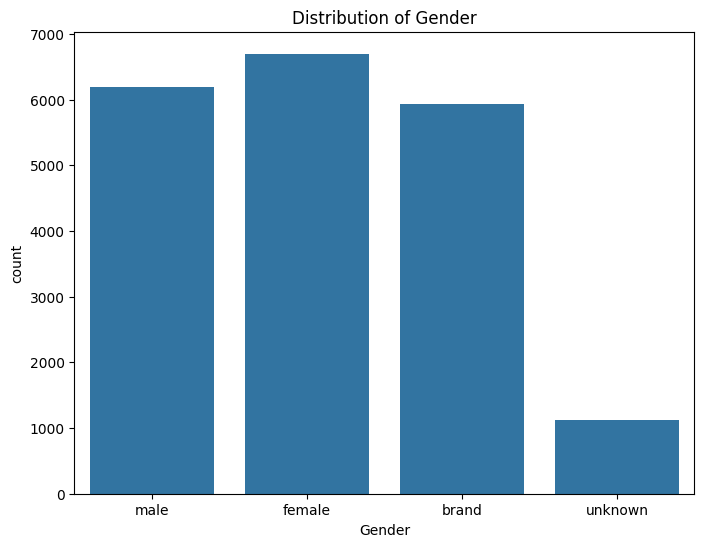

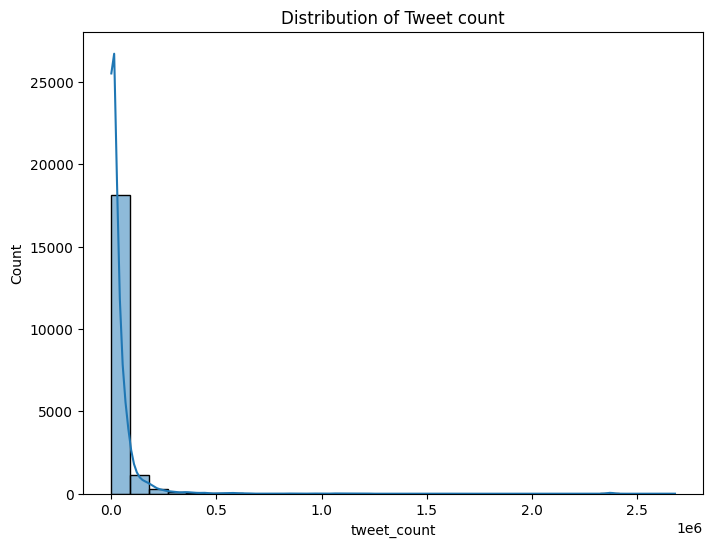

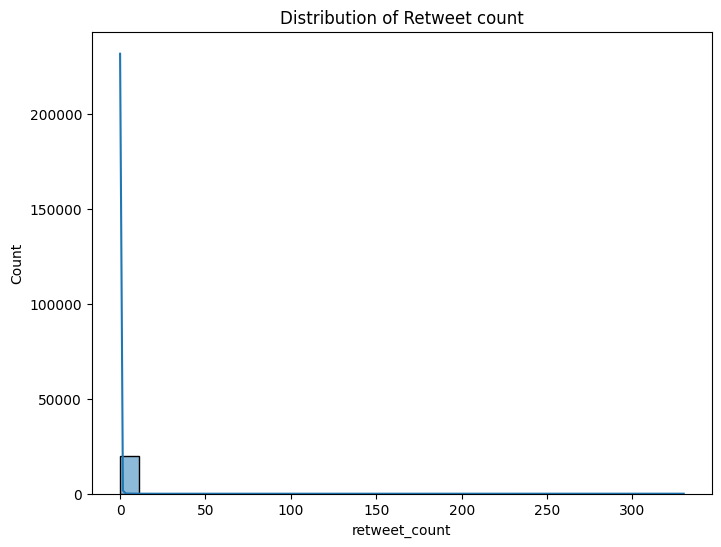

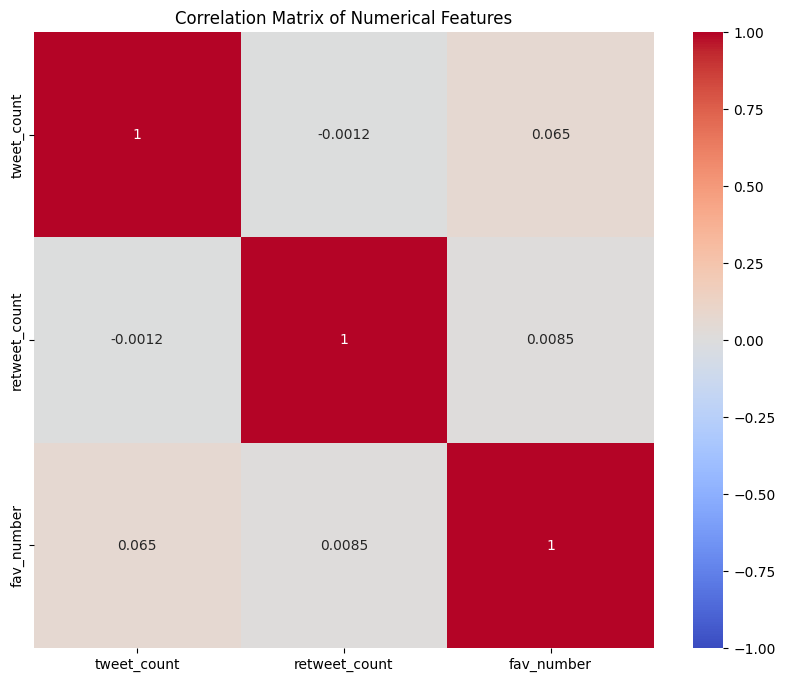

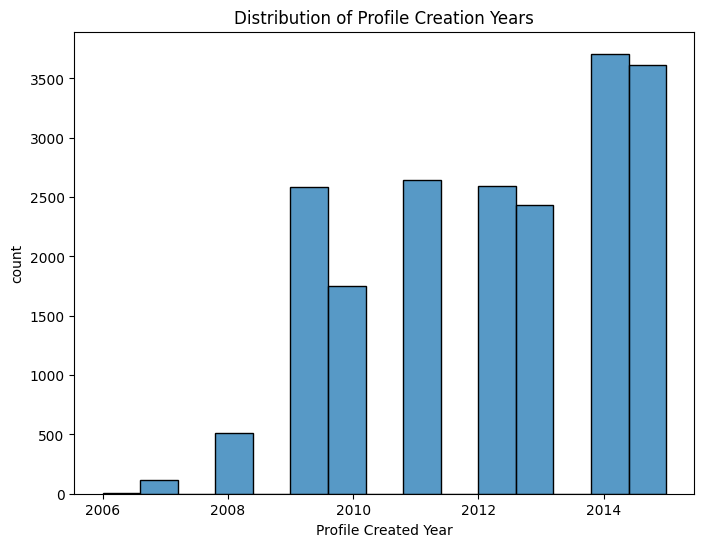

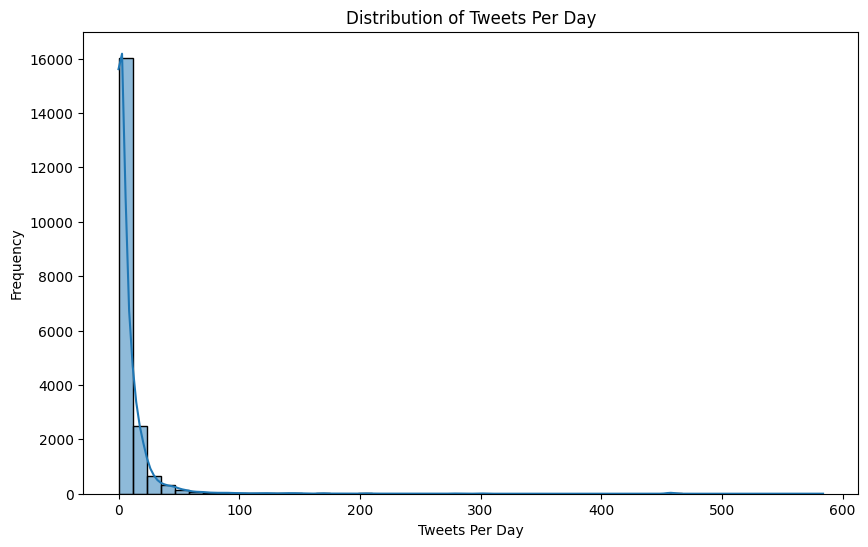

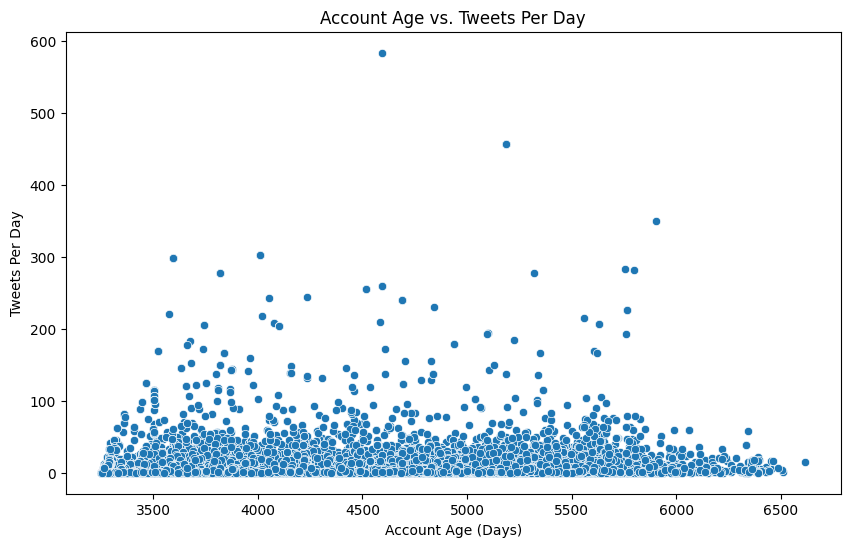

In [4]:
all_features = df.columns
#Finding features that have a lot of missing data
def find_columns_with_missing(data, columns):
    missing = []
    i = 0
    for col in columns:
        missing.append(data[col].isnull().sum())
        print(f'the {col} has {missing[i]} data missing')
        print(f'the proportion of missing data to the total is {missing[i]/len(data)}')
        if missing[i]/len(data) >= 0.9:
            print(f'The feature to be dropped is {col}')
            data = data.drop(columns=col)
            data_cleaned = data
        i += 1
    return missing, data_cleaned

missing_col, df_cleaned = find_columns_with_missing(df, all_features)
missing_col
print('The information of the cleaned dataset')
print(df_cleaned.info())
print('The first few rows of the cleaned dataset')
print(df_cleaned.head())

# Dropping rows where 'gender' is missing
df_cleaned = df_cleaned.dropna(subset=['gender'])

# Drop the 'profile_yn' column since it is not relevant to human/non-human classification
df_cleaned = df_cleaned.drop(columns=['profile_yn'])

# Now that we have handled the missing data, you can proceed with further analysis
print('The information of the cleaned dataset')
print(df_cleaned.info())
print('The first few rows of the cleaned dataset')
print(df_cleaned.head())

# Exploratory Data Analysis (EDA)
current_num_features = df.select_dtypes(include=[np.number])

# Plot distribution of each numerical feature with gender as hue using seaborn
for feature in current_num_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_cleaned, x=feature, hue='gender', bins=30, kde=True)
    plt.title(f'Distribution of {feature} by Gender')
    plt.show()

# Distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df_cleaned)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()

# Plot distribution of 'tweet_count' and 'retweet_count'
for column in ['tweet_count', 'retweet_count']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_cleaned, x=column, kde=True, bins=30)
    plt.title(f'Distribution of {column.replace("_", " ").capitalize()}')
    plt.show()

# Correlation analysis for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned[['tweet_count', 'retweet_count', 'fav_number']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Extracting date from 'created' and 'tweet_created' for time-based analysis
df_cleaned['profile_created_year'] = pd.to_datetime(df_cleaned['created']).dt.year
df_cleaned['tweet_created_year'] = pd.to_datetime(df_cleaned['tweet_created']).dt.year

# Ensure 'created' and tweet_created are in datetime format
df_cleaned['created'] = pd.to_datetime(df_cleaned['created'], errors='coerce')
df_cleaned['tweet_created'] = pd.to_datetime(df_cleaned['tweet_created'], errors='coerce')

#assuming the data was up-to-date
df_cleaned['account_age'] = (pd.Timestamp.now() - df_cleaned['created']).dt.days

df_cleaned['tweets_per_day'] = df_cleaned['tweet_count'] / df_cleaned['account_age']
df_cleaned['retweets_per_day'] = df_cleaned['retweet_count'] / df_cleaned['account_age']
df_cleaned['favorites_per_day'] = df_cleaned['fav_number'] / df_cleaned['account_age']

# Plotting the distribution of profile creation over the years
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['profile_created_year'], kde=False, bins=15)
plt.title('Distribution of Profile Creation Years')
plt.xlabel('Profile Created Year')
plt.ylabel('count')
plt.show()

# Plotting the histogram of tweets per day
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['tweets_per_day'], bins=50, kde=True)
plt.title('Distribution of Tweets Per Day')
plt.xlabel('Tweets Per Day')
plt.ylabel('Frequency')
plt.show()

#show the relationship between account age and tweets per day
plt.figure(figsize=(10, 6))
sns.scatterplot(x='account_age', y='tweets_per_day', data=df_cleaned)
plt.title('Account Age vs. Tweets Per Day')
plt.xlabel('Account Age (Days)')
plt.ylabel('Tweets Per Day')
plt.show()

Number of NaN values in 'link_color': 0
Number of NaN values in 'sidebar_color': 0
the number of link color is 2986
the number of side bar color is 559
Number of NaN values in 'link_color': 0
Number of NaN values in 'sidebar_color': 0


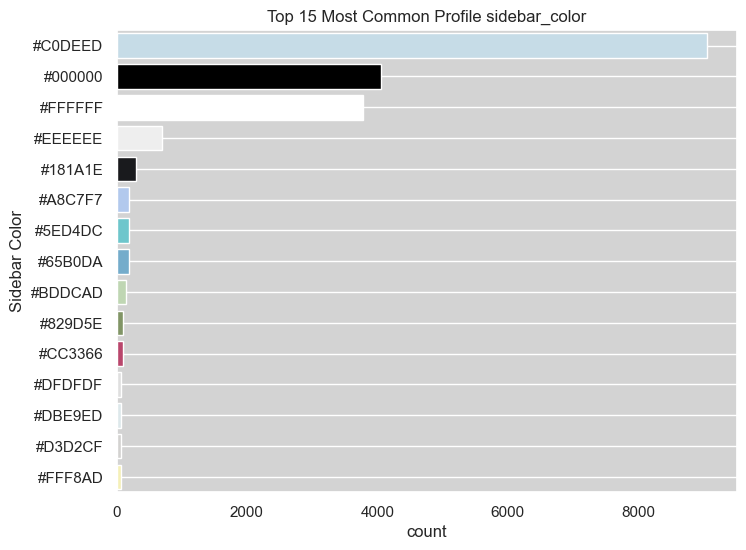

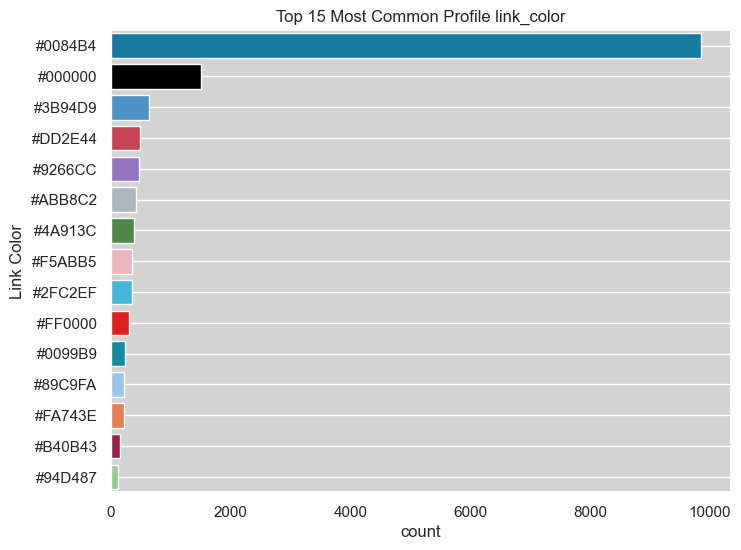

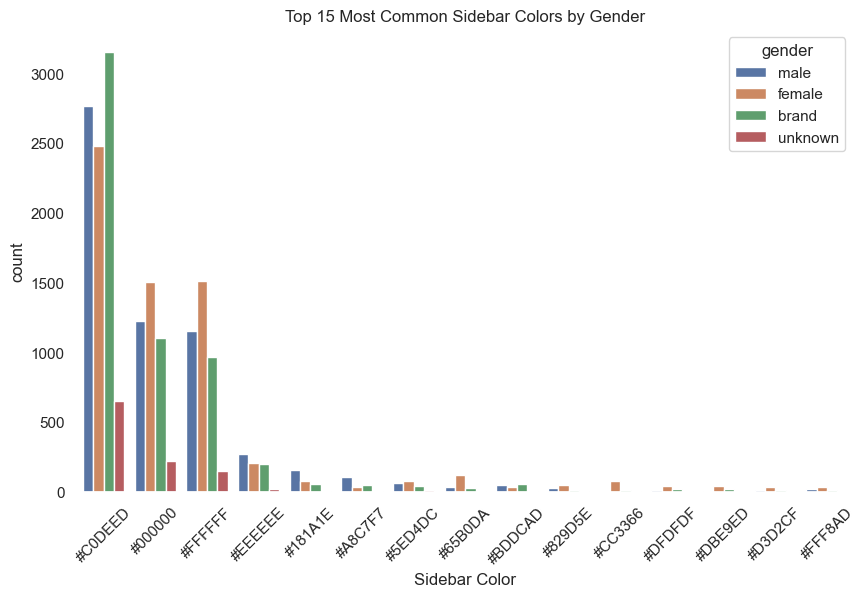

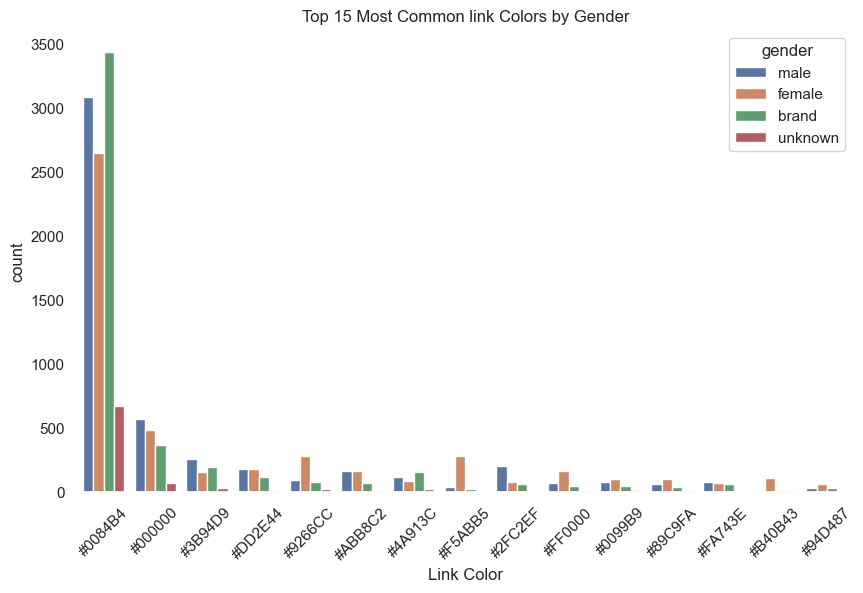

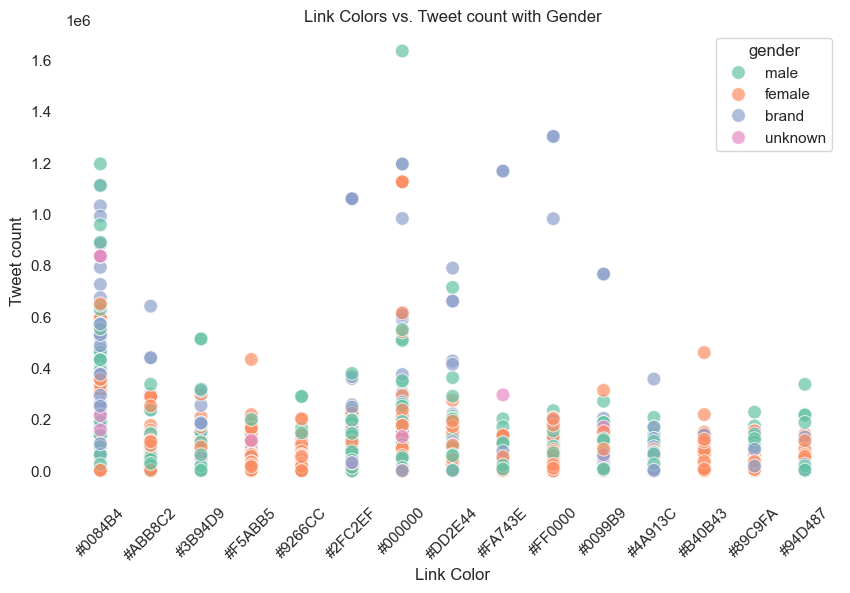

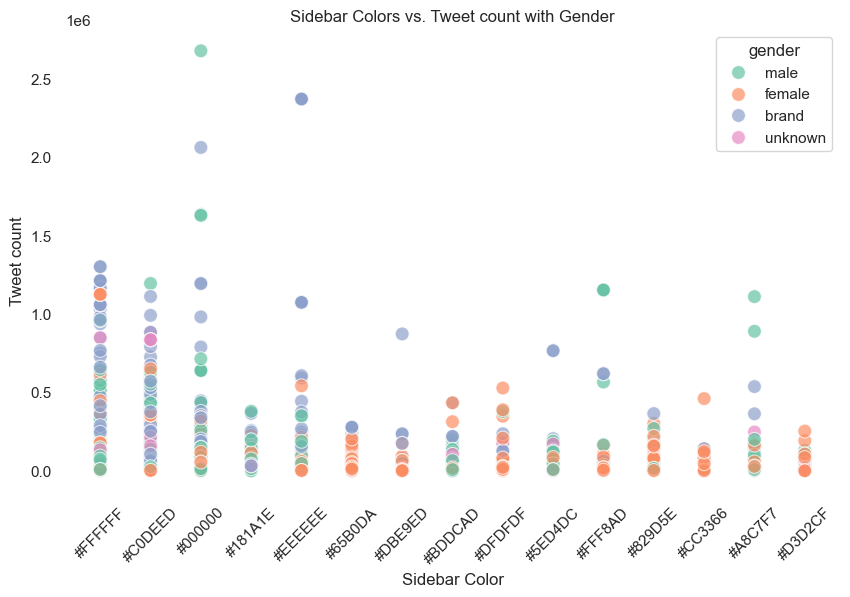

In [5]:
# Exploring 'link_color' and 'sidebar_color' features

#Check number of NaN value in  'link_color' and 'sidebar_color' features
link_color_nan_count = df_cleaned['link_color'].isnull().sum()
sidebar_color_nan_count = df_cleaned['sidebar_color'].isnull().sum()

print(f"Number of NaN values in 'link_color': {link_color_nan_count}")
print(f"Number of NaN values in 'sidebar_color': {sidebar_color_nan_count}")

#Check how many available colors in 'link_color' and 'sidebar_color' features
link_color_count = len(df_cleaned['link_color'].unique())
sidebar_color_count = len(df_cleaned['sidebar_color'].unique())
print(f'the number of link color is {link_color_count}')
print(f'the number of side bar color is {sidebar_color_count}')

# Apply the function to 'link_color' and 'sidebar_color'
df_cleaned['link_color'] = df_cleaned['link_color'].apply(lambda x: f'#{x}' if len(x) == 6 else '#000000')
df_cleaned['sidebar_color'] = df_cleaned['sidebar_color'].apply(lambda x: f'#{x}' if len(x) == 6 else '#000000')

# Drop rows where 'sidebar_color' is still NaN
df_cleaned = df_cleaned.dropna(subset=['link_color'])
df_cleaned = df_cleaned.dropna(subset=['sidebar_color'])
print(f"Number of NaN values in 'link_color': {df_cleaned['link_color'].isnull().sum()}")
print(f"Number of NaN values in 'sidebar_color': {df_cleaned['sidebar_color'].isnull().sum()}")

#top 15 colors
top_sidebar_colors = df_cleaned['sidebar_color'].value_counts().iloc[:15].index.tolist()
top_link_colors = df_cleaned['link_color'].value_counts().iloc[:15].index.tolist()
#print(top_sidebar_colors)

# Extract top 10 most common sidebar colors 
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
plt.figure(figsize=(8, 6))
sns.countplot(y='sidebar_color', data=df_cleaned, order=df_cleaned['sidebar_color'].value_counts().iloc[:15].index, palette=top_sidebar_colors)
plt.title('Top 15 Most Common Profile sidebar_color')
plt.ylabel('Sidebar Color')
plt.xlabel('count')
plt.grid()
plt.show()

# Extract top 10 most common link colors 
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
plt.figure(figsize=(8, 6))
sns.countplot(y='link_color', data=df_cleaned, order=df_cleaned['link_color'].value_counts().iloc[:15].index, palette=top_link_colors)
plt.title('Top 15 Most Common Profile link_color')
plt.ylabel('Link Color')
plt.xlabel('count')
plt.grid()
plt.show()

# count plot for sidebar_color vs. gender
plt.figure(figsize=(10, 6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.countplot(x='sidebar_color', hue='gender', data=df_cleaned, 
              order=df_cleaned['sidebar_color'].value_counts().iloc[:15].index)
plt.title('Top 15 Most Common Sidebar Colors by Gender')
plt.xlabel('Sidebar Color')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

# count plot for link_color vs. gender
plt.figure(figsize=(10, 6))
sns.countplot(x='link_color', hue='gender', data=df_cleaned, 
              order=df_cleaned['link_color'].value_counts().iloc[:15].index)
plt.title('Top 15 Most Common link Colors by Gender')
plt.xlabel('Link Color')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

# Scatter plot for link_color vs. tweet_count with gender as hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='link_color', y='tweet_count', hue='gender', data=df_cleaned[df_cleaned['link_color'].isin(top_link_colors)], 
                palette='Set2', s=100, alpha=0.7)
plt.title('Link Colors vs. Tweet count with Gender')
plt.xlabel('Link Color')
plt.ylabel('Tweet count')
plt.xticks(rotation=45)
plt.show()

# Scatter plot for sidebar_color vs. tweet_count with gender as hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sidebar_color', y='tweet_count', hue='gender', data=df_cleaned[df_cleaned['sidebar_color'].isin(top_sidebar_colors)], 
                palette='Set2', s=100, alpha=0.7)
plt.title('Sidebar Colors vs. Tweet count with Gender')
plt.xlabel('Sidebar Color')
plt.ylabel('Tweet count')
plt.xticks(rotation=45)
plt.show()

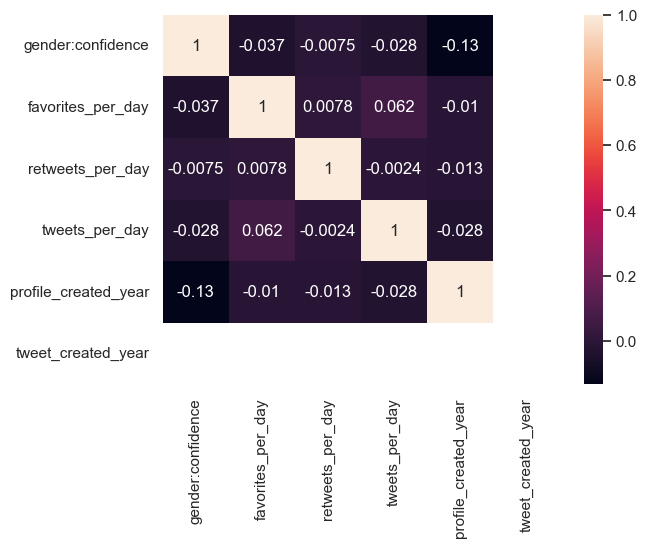

In [6]:
# Select columns to be used
col = ['gender', 'gender:confidence', 'description', 'favorites_per_day','link_color',
       'retweets_per_day', 'sidebar_color', 'text', 'tweets_per_day','user_timezone', 'tweet_location', 'profile_created_year', 'tweet_created_year'
       ]
df_preprocessed = df_cleaned[col].copy()
# Remove rows where gender is 'Unknown'
df_preprocessed = df_preprocessed[df_preprocessed['gender'] != 'unknown']

# Plot correlation matrix
corr_matrix = df_preprocessed.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Drop one feature from highly correlated pairs (correlation > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_preprocessed = df_preprocessed.drop(columns=to_drop)

# Filling missing values for important features
df_preprocessed['user_timezone'].fillna('Unknown', inplace=True)
df_preprocessed['tweet_location'].fillna('Unknown', inplace=True)
categorical_features = ['user_timezone', 'tweet_location']

[0 1 2]
<class 'pandas.core.frame.DataFrame'>
Index: 18836 entries, 0 to 20049
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  18836 non-null  int64  
 1   gender:confidence       18836 non-null  float64
 2   description             15522 non-null  object 
 3   favorites_per_day       18836 non-null  float64
 4   link_color              18836 non-null  object 
 5   retweets_per_day        18836 non-null  float64
 6   sidebar_color           18836 non-null  object 
 7   text                    18836 non-null  object 
 8   tweets_per_day          18836 non-null  float64
 9   user_timezone           18836 non-null  object 
 10  tweet_location          18836 non-null  object 
 11  profile_created_year    18836 non-null  int32  
 12  tweet_created_year      18836 non-null  int32  
 13  tweet_location_encoded  18836 non-null  float64
 14  user_timezone_encoded   18836 non-n

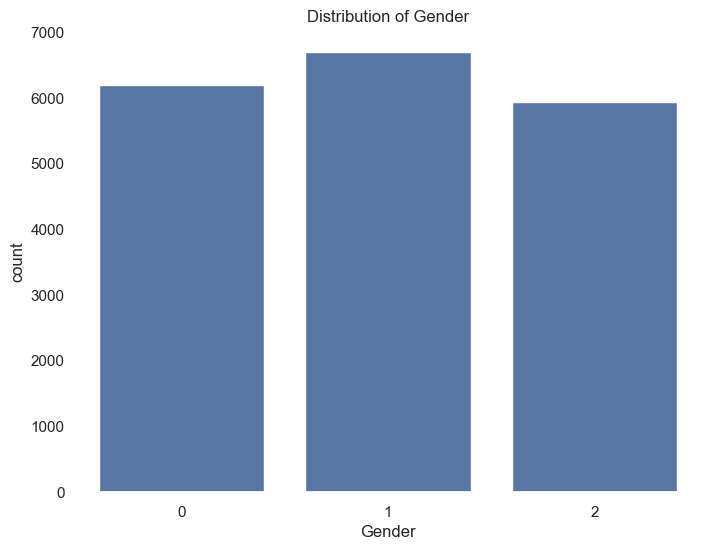

In [7]:
#categorise types of features

#numerical features
df_num = df_preprocessed[['retweets_per_day', 'favorites_per_day', 'tweets_per_day', 'profile_created_year', 'tweet_created_year']].copy()

#categorical features with frequency encoding
freq_encoding_location = df_preprocessed['tweet_location'].value_counts(normalize=True)
df_preprocessed['tweet_location_encoded'] = df_preprocessed['tweet_location'].map(freq_encoding_location)

freq_encoding_timezone = df_preprocessed['user_timezone'].value_counts(normalize=True)
df_preprocessed['user_timezone_encoded'] = df_preprocessed['user_timezone'].map(freq_encoding_timezone)

df_cate = df_preprocessed[['tweet_location_encoded', 'user_timezone_encoded']].copy()

#gender features
#encode the 'gender' column to numeric values
df_preprocessed['gender'] = df_preprocessed['gender'].replace({'male': 0, 'female': 1, 'brand': 2})

# Check for unique values in the 'gender' column after replacement
print(df_preprocessed['gender'].unique())
print(df_preprocessed.info())

# Distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df_preprocessed)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()

df_gender = df_preprocessed[['gender', 'gender:confidence']].copy()

# Drop the original categorical columns
df_preprocessed = df_preprocessed.drop(columns=categorical_features)

In [8]:
# Function to convert hex to RGB
def hex_to_rgb(hex_color):
    # Remove the '#' if it exists
    hex_color = hex_color.lstrip('#')
    
    # Convert hex to integer and split into RGB components
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

# Convert 'link_color' values
df_preprocessed['link_color_rgb'] = df_preprocessed['link_color'].apply(lambda x: hex_to_rgb(x) if isinstance(x, str) else (0,0,0))
# Convert 'sidebar_color' values
df_preprocessed['sidebar_color_rgb'] = df_preprocessed['sidebar_color'].apply(lambda x: hex_to_rgb(x) if isinstance(x, str) else (0,0,0))

rgb_df = pd.DataFrame(df_preprocessed['link_color_rgb'].to_list(), columns=['link_R', 'link_G', 'link_B'])
rgb_df = pd.concat([rgb_df, pd.DataFrame(df_preprocessed['sidebar_color_rgb'].to_list(), columns=['sidebar_R', 'sidebar_G', 'sidebar_B'])], axis=1)

#Drop the original color features
df_preprocessed = df_preprocessed.drop(columns=['link_color', 'sidebar_color', 'link_color_rgb', 'sidebar_color_rgb'])

#Check if all required features are there
print(f'All features that will be used are {df_preprocessed.columns.tolist()}')

# Define the numerical features to scale (filtering for int64 and float64 columns)
numerical_features = df_preprocessed.select_dtypes(include=[np.number])
#print(f'All current numerical features are {numerical_features.columns.tolist()}')

print('After all, here is the information of the dataset')
print(df_preprocessed.info())

All features that will be used are ['gender', 'gender:confidence', 'description', 'favorites_per_day', 'retweets_per_day', 'text', 'tweets_per_day', 'profile_created_year', 'tweet_created_year', 'tweet_location_encoded', 'user_timezone_encoded']
After all, here is the information of the dataset
<class 'pandas.core.frame.DataFrame'>
Index: 18836 entries, 0 to 20049
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  18836 non-null  int64  
 1   gender:confidence       18836 non-null  float64
 2   description             15522 non-null  object 
 3   favorites_per_day       18836 non-null  float64
 4   retweets_per_day        18836 non-null  float64
 5   text                    18836 non-null  object 
 6   tweets_per_day          18836 non-null  float64
 7   profile_created_year    18836 non-null  int32  
 8   tweet_created_year      18836 non-null  int32  
 9   tweet_locati

In [9]:
# NLP Processing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

df_preprocessed['description'].fillna('', inplace=True)
df_preprocessed['text'].fillna('', inplace=True)
#df_preprocessed['name'].fillna('', inplace=True)

#Check the text features if they still contain NaN
print(df_preprocessed.select_dtypes(include=[object]))


# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    #Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))  # Removes punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)  
    #Tokenize the text
    tokens = word_tokenize(text)
    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    #Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the 'description', 'text', and 'name' columns
df_preprocessed['cleaned_description'] = df_preprocessed['description'].apply(lambda x: preprocess_text(str(x)))
df_preprocessed['cleaned_text'] = df_preprocessed['text'].apply(lambda x: preprocess_text(str(x)))
#df_preprocessed['cleaned_name'] = df_preprocessed['name'].apply(lambda x: preprocess_text(str(x)))

# Check the preprocessed data with preprocessed text features
print(df_preprocessed[['description', 'cleaned_description', 'text', 'cleaned_text']].head())

#Drop the original text features
df_preprocessed = df_preprocessed.drop(columns=['description','text'])

#Check the preprocessed dataset in the present
print('The current information of pre-processed dataset before text preprocessing')
print(df_preprocessed.info())

                                             description  \
0                                  i sing my own rhythm.   
1      I'm the author of novels filled with family dr...   
2                    louis whining and squealing and all   
3      Mobile guy.  49ers, Shazam, Google, Kleiner Pe...   
4      Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...   
...                                                  ...   
20045                                               (rp)   
20046  Whatever you like, it's not a problem at all. ...   
20047  #TeamBarcelona ..You look lost so you should f...   
20048  Anti-statist; I homeschool my kids. Aspiring t...   
20049                     Teamwork makes the dream work.   

                                                    text  
0      Robbie E Responds To Critics After Win Against...  
1      ÛÏIt felt like they were my friends and I was...  
2      i absolutely adore when louis starts the songs...  
3      Hi @JordanSpieth - Looking at the ur

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\htp898\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\htp898\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\htp898\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\htp898\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                         description  \
0                              i sing my own rhythm.   
1  I'm the author of novels filled with family dr...   
2                louis whining and squealing and all   
3  Mobile guy.  49ers, Shazam, Google, Kleiner Pe...   
4  Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...   

                                 cleaned_description  \
0                                        sing rhythm   
1        im author novel filled family drama romance   
2                            louis whining squealing   
3  mobile guy er shazam google kleiner perkins ya...   
4  ricky wilson best frontmankaiser chief best ba...   

                                                text  \
0  Robbie E Responds To Critics After Win Against...   
1  ÛÏIt felt like they were my friends and I was...   
2  i absolutely adore when louis starts the songs...   
3  Hi @JordanSpieth - Looking at the url - do you...   
4  Watching Neighbours on Sky+ catching up wit

In [10]:
# Initialize TFIDF vectorizer for text features
tfidf_vectorizer = TfidfVectorizer(max_features=1500, stop_words='english')

# Apply TF-IDF on 'description', 'text', 'name' columns

tfidf_description = tfidf_vectorizer.fit_transform(df_preprocessed['cleaned_description']).toarray()
tfidf_text = tfidf_vectorizer.fit_transform(df_preprocessed['cleaned_text']).toarray()
#tfidf_name = tfidf_vectorizer.fit_transform(df_preprocessed['cleaned_name']).toarray()

# Convert TF-IDF into DataFrames and add to df_preprocessed
tfidf_desc_df = pd.DataFrame(tfidf_description, columns=[f'desc_{i}' for i in range(tfidf_description.shape[1])])
tfidf_text_df = pd.DataFrame(tfidf_text, columns=[f'text_{i}' for i in range(tfidf_text.shape[1])])
#tfidf_name_df = pd.DataFrame(tfidf_name, columns=[f'name_{i}' for i in range(tfidf_name.shape[1])])

# Merge with main dataframe
df_preprocessed = pd.concat([df_preprocessed.reset_index(drop=True), tfidf_desc_df, tfidf_text_df], axis=1)

#Drop the cleaned text features
df_preprocessed = df_preprocessed.drop(columns=['cleaned_description', 'cleaned_text'])

df_preprocessed = pd.concat([df_preprocessed, rgb_df], axis=1)

df_preprocessed = pd.concat([df_preprocessed, rgb_df], axis=1)